#### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import math
import control as ct
import scienceplots
plt.style.use(['science','ieee','no-latex'])
s = ct.TransferFunction.s


#experiment params
set_t = 280

#### Functions to run the show

In [3]:
def unnormalise(tempcol_normalized, set_t):
    templist = list(max(tempcol) - (tempcol_normalized * (max(tempcol) - set_t)))
    return templist

In [4]:
def normalise(tempcol, set_t):
    templist = list((max(tempcol) - np.array(tempcol)) / (max(tempcol) - set_t))
    return templist

In [5]:
def log_file_reader(filename, set_t):

    # Load data from file
    datetimecol = []
    tempcol = []
    
    
    
    with open(filename) as f:
        for line in f:
            temp = line.strip().split()
            datetimecol.append(temp[0] + ' ' + temp[1])
            tempcol.append(float(temp[2]))
    
    # Convert datetime strings to datetime objects
    time_series = pd.to_datetime(datetimecol)
    
    # Calculate elapsed time in seconds since the start
    elapsed_time_seconds = (time_series - time_series[0]).total_seconds()
    
    return [elapsed_time_seconds, tempcol]

In [6]:
def characterize(time, y, set_t):
    
    # Find peak temperature and peak time
    y_peak = min(y)
    index_peak = y.index(y_peak)
    peak_time = (time[index_peak])
        
    overshoot = ((y_peak - set_t)/set_t)     
    damp_f = math.sqrt( 1 / ( 1 + ( (math.pi**2) / ((math.log(np.abs(overshoot)))**2) )))
    w_n = math.pi / (peak_time * math.sqrt(1 - (damp_f ** 2)))    
    theta = (math.atan(math.sqrt((1-(damp_f**2))/damp_f)))
    rise_time = (math.pi - theta)/(w_n * math.sqrt(1-(damp_f**2)))
    
    print("Peak temperature:", y_peak, "K")
    print("Percentage overshoot:", round((overshoot*100), 3), "%")
    print("Peak time:", round(peak_time, 3), "s")
    print("Rise time:", round(rise_time, 3), "s")    
    print("Damping Factor:", round(damp_f,3))
    print("Natural Frequency:", round(w_n,3), "rad/s")

    return [y_peak, peak_time, overshoot, rise_time, damp_f, w_n]

In [7]:
def custom_model_maker(P, C, copper_plate_TF):
    T = ct.feedback(C * P * copper_plate_TF, 1)
    print(T)
    time = list(np.arange(0, 2000, 0.01))
    _, y = ct.step_response(T, time)
    #print(y)
    y_unnorm = unnormalise(y, set_t)
        
    return time, y_unnorm, T

In [8]:
def model_and_tuned_system_maker(w_n, damp_f, kp, ki, kd, kp_new, ki_new, kd_new, kp_tuned, ki_tuned, kd_tuned):
    '''
    Good old code that shall remove previous PID, hence extracting Plant, add new PID TF
    Alongside getting the model response, it also takes in tuned kp ki kd values and 
    gives the tuned system response
    '''
    
    P = (w_n ** 2) / (((s ** 2) * kd + s * kp + ki) * (s + 2 * w_n * damp_f))  
    
    #add new pid (model the present system)
    C = ct.TransferFunction([kd_new, kp_new, ki_new], [1, 0])
    T = ct.feedback(C * P, 1)
    
    t_model = list(np.arange(0, 2000, 0.01))
    _, y_model = ct.step_response(T, t_model)
    y_model_unnorm = unnormalise(y_model, set_t)
        
    C_tuned = ct.TransferFunction([kd_tuned, kp_tuned, ki_tuned], [1, 0])
    T_tuned = ct.feedback(C_tuned * P, 1)
    
    t_tuned = list(np.arange(0, 2000, 0.01))
    _, y_tuned = ct.step_response(T_tuned, t_tuned)
    y_tuned_unnorm = unnormalise(y_tuned, set_t)

    return [t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, P, C, T]

In [9]:
def exp_model_tuned_plotter(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, set_t, save):
    #exp plot
    plt.plot(elapsed_time_seconds, tempcol, color='r', label = 'Exp Plot')

    #model plotting
    plt.plot(t_model, y_model_unnorm, color='k', label = 'Model Plot')    

    # after tuning
    plt.plot(t_tuned, y_tuned_unnorm, color='m',label = 'Tuned PID')
    plt.axvline(x = rise_time, color='y', linestyle='--', linewidth = 0.5, label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 1)} s')
    # plt.axvline(x = peak_timeseries_model, color='b', linestyle='--', linewidth = 0.5, label = '$\mathregular{t_p}$: ' + f'{round(peak_timeseries_model, 1)} s')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")
    plt.title('Closed loop Response for Exp, Model and after Tuning')
    
    if save:
        plt.savefig('log_3105_model_tuned_exp.pdf', dpi=300)
    plt.show()

In [47]:
def characterized_system_plotter(heading, x, y, rise_time, peak_time, set_t, save):
    
    plt.plot(x, y, color='k', label = f'{heading}')
    
    plt.axvline(x = rise_time, color='y', linestyle='--', label = '$\mathregular{t_r}$: ' + f'{round(rise_time, 2)} s')
    plt.axvline(x = peak_time, color='b', linestyle='--', label = '$\mathregular{t_p}$: ' + f'{round(peak_time, 2)} s')
    plt.axhline(y = set_t, color='m', linestyle='--', label = f'{set_t} K')
    plt.axhline(max(y), linestyle='dashed', color='r', linewidth = 0.5, label = f'{round(max(y),2)} K')  # Adjusted dashed line
    plt.axhline(min(y), linestyle='dashed', color='g', linewidth = 0.5, label = f'{round(min(y),2)} K')  # Adjusted dashed line

    plt.title(f'Characterizing the {heading}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc="best")

    if save:
        plt.savefig(f'log_3105_{heading}_character.pdf', dpi=300)
    plt.show()

In [11]:
def basic_plotter(name, x, y, set_t, save):
    plt.plot(x, y, label = f'{name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.axhline(set_t, linestyle='--', linewidth = 0.5,  color='m', label = 'Set point')
    
    plt.legend(loc="best")
    
    if save:
        plt.savefig(f'log_3105_{name}.pdf', dpi=300)
    plt.show()

### READING THE LOG FILE AND PLOTTING THE TIME RESPONSE

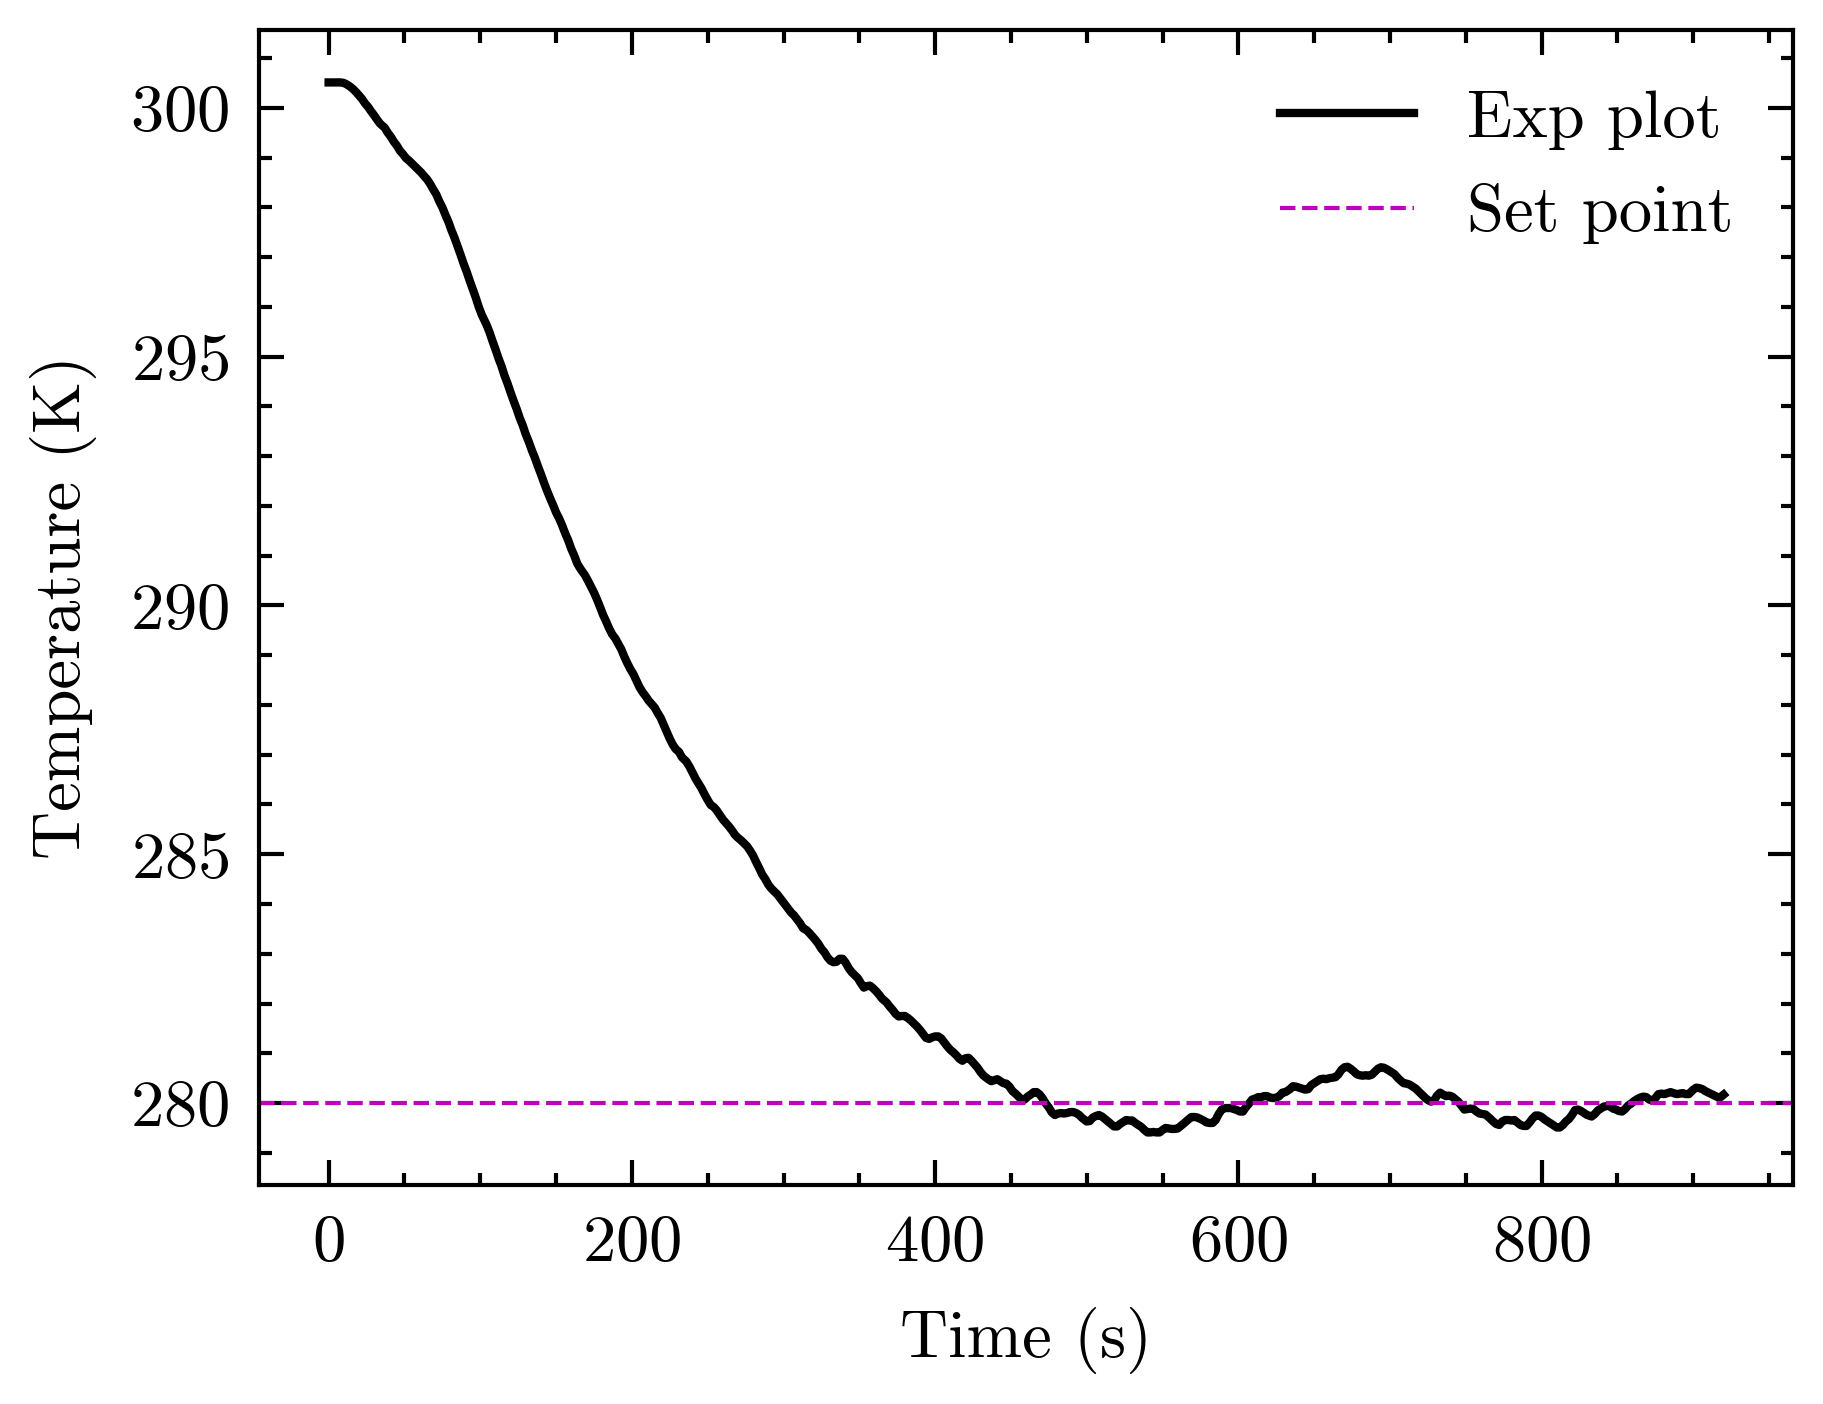

In [12]:
[elapsed_time_seconds, tempcol] = log_file_reader("templog_2024-05-31_10-16-34_to_2024-05-31_10-31-54.txt", set_t)
basic_plotter('Exp plot', elapsed_time_seconds, tempcol, set_t, False)

### CHARACTERIZE THE LOG DATA
### PLOTTING THE CLOSED LOOP TF OF EXPERIMENT, MODEL, AFTER TUNING

In [13]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(elapsed_time_seconds, tempcol, set_t)
[t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, P, C, T] = model_and_tuned_system_maker(w_n, damp_f, 5, 0.5, 0.2, 5, 0.5, 0.2, 138.675, 4.1025, 1024.7449)

Peak temperature: 279.41 K
Percentage overshoot: -0.211 %
Peak time: 540.0 s
Rise time: 462.911 s
Damping Factor: 0.891
Natural Frequency: 0.013 rad/s


##### Open loop Plant TF

In [14]:
P

TransferFunction(array([0.00016408]), array([0.2       , 5.00456476, 0.61411893, 0.01141189]))

##### Controller TF

In [15]:
C

TransferFunction(array([0.2, 5. , 0.5]), array([1, 0]))

##### Overall TF with feedback

In [16]:
T

TransferFunction(array([3.28155374e-05, 8.20388436e-04, 8.20388436e-05]), array([2.00000000e-01, 5.00456476e+00, 6.14151748e-01, 1.22322817e-02,
       8.20388436e-05]))

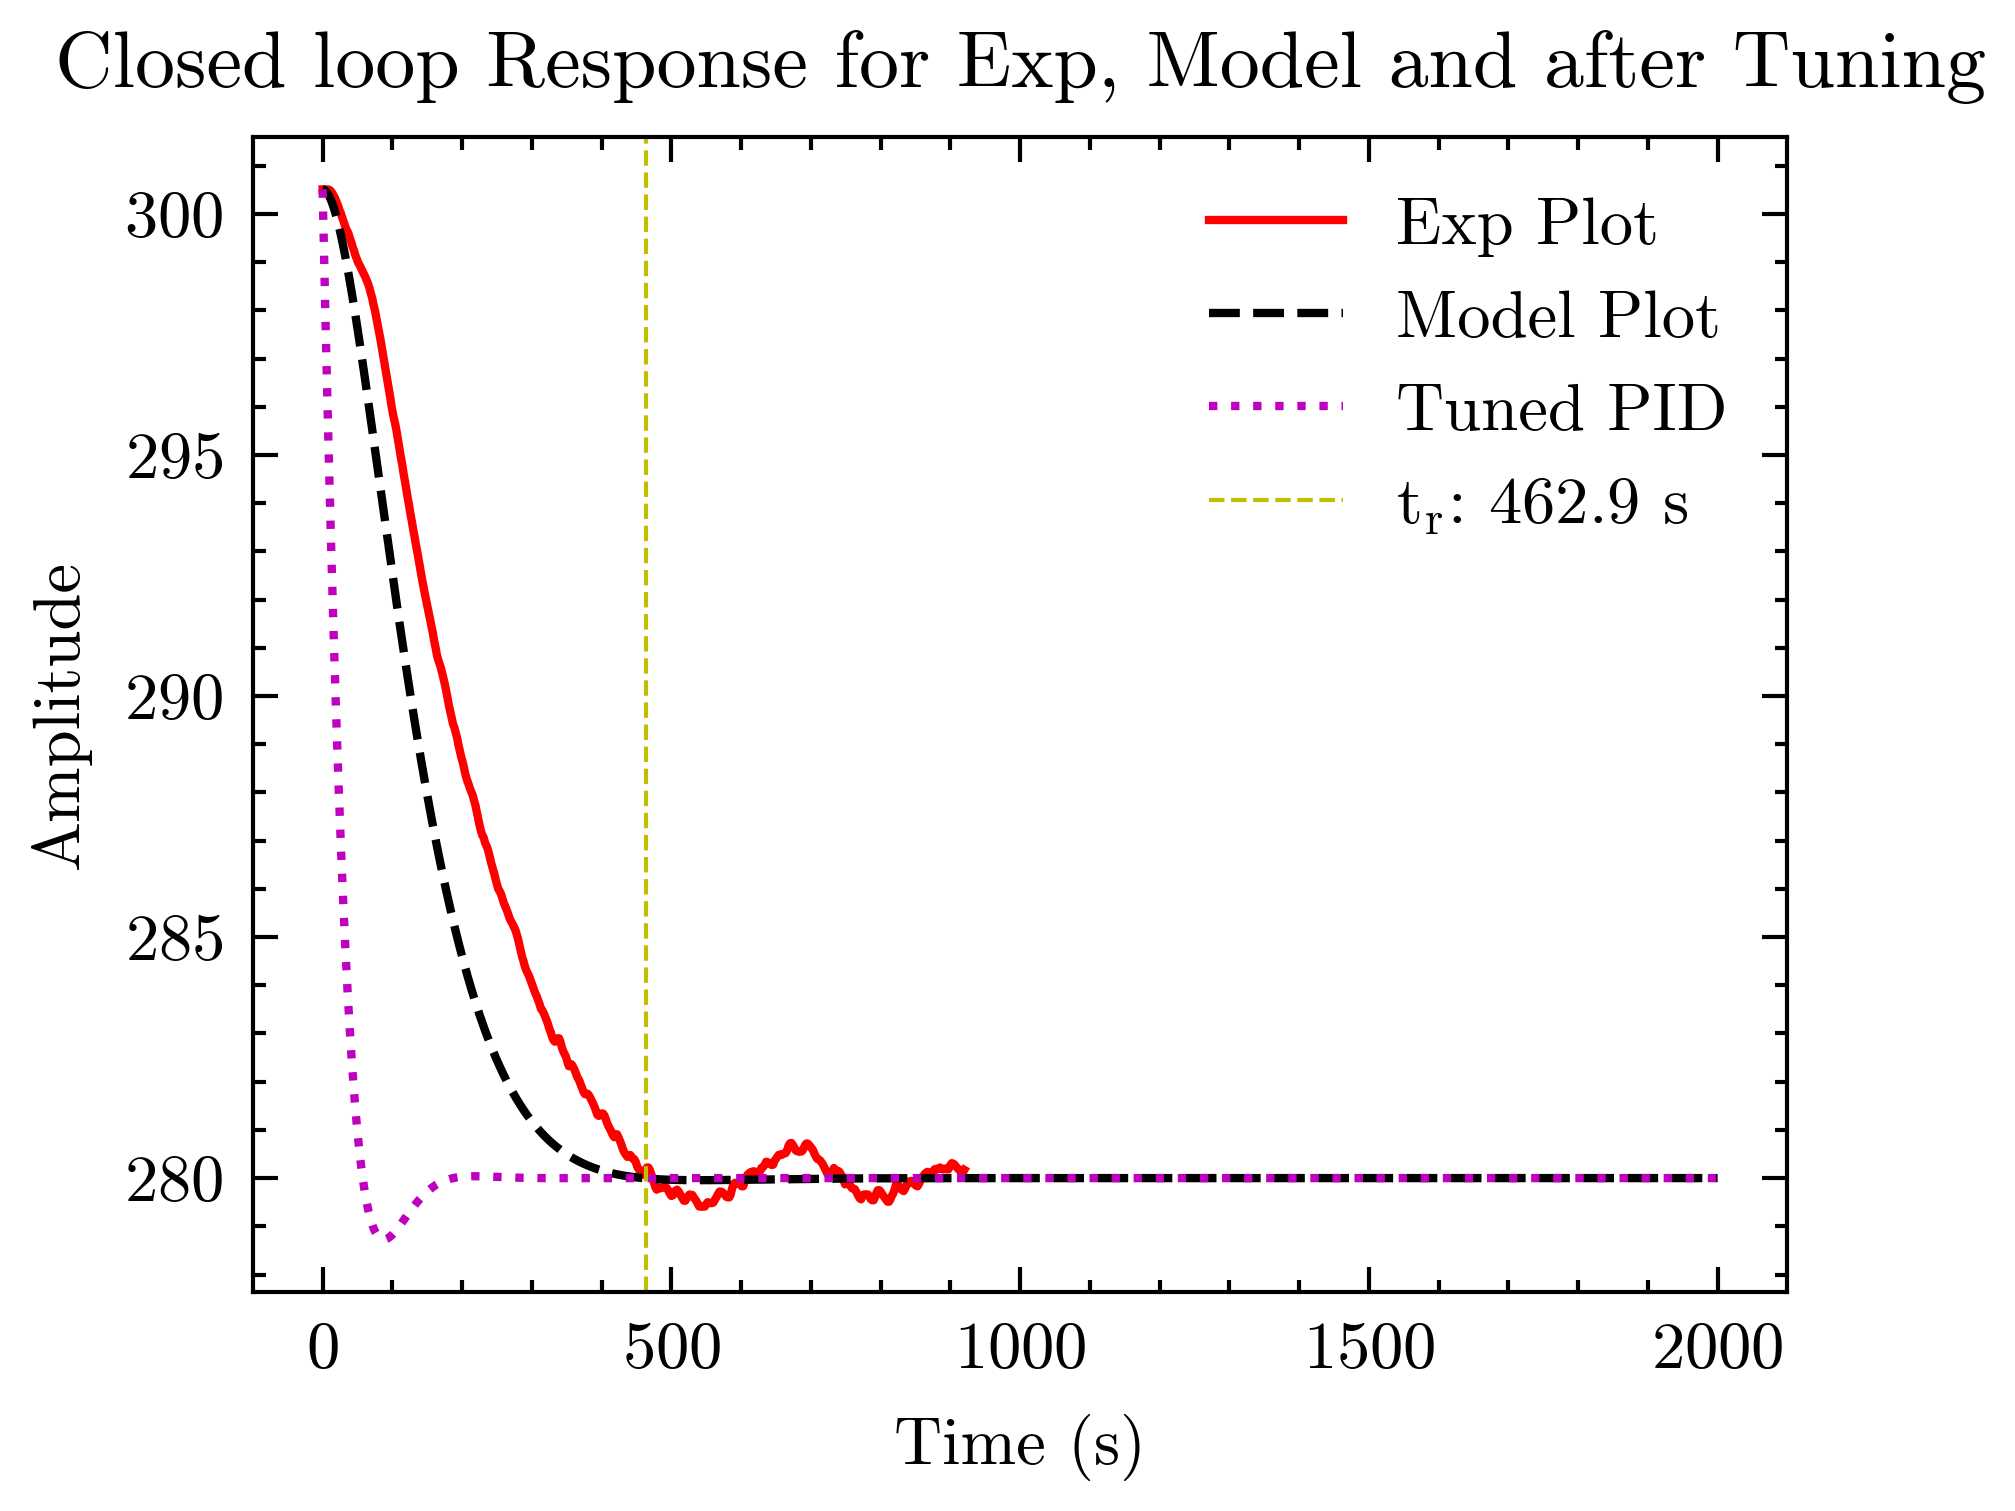

In [17]:
exp_model_tuned_plotter(elapsed_time_seconds, tempcol, t_model, y_model_unnorm, t_tuned, y_tuned_unnorm, set_t, False)

#### CHARACTERIZE THE LOG DATA

Peak temperature: 279.41 K
Percentage overshoot: -0.211 %
Peak time: 540.0 s
Rise time: 462.911 s
Damping Factor: 0.891
Natural Frequency: 0.013 rad/s


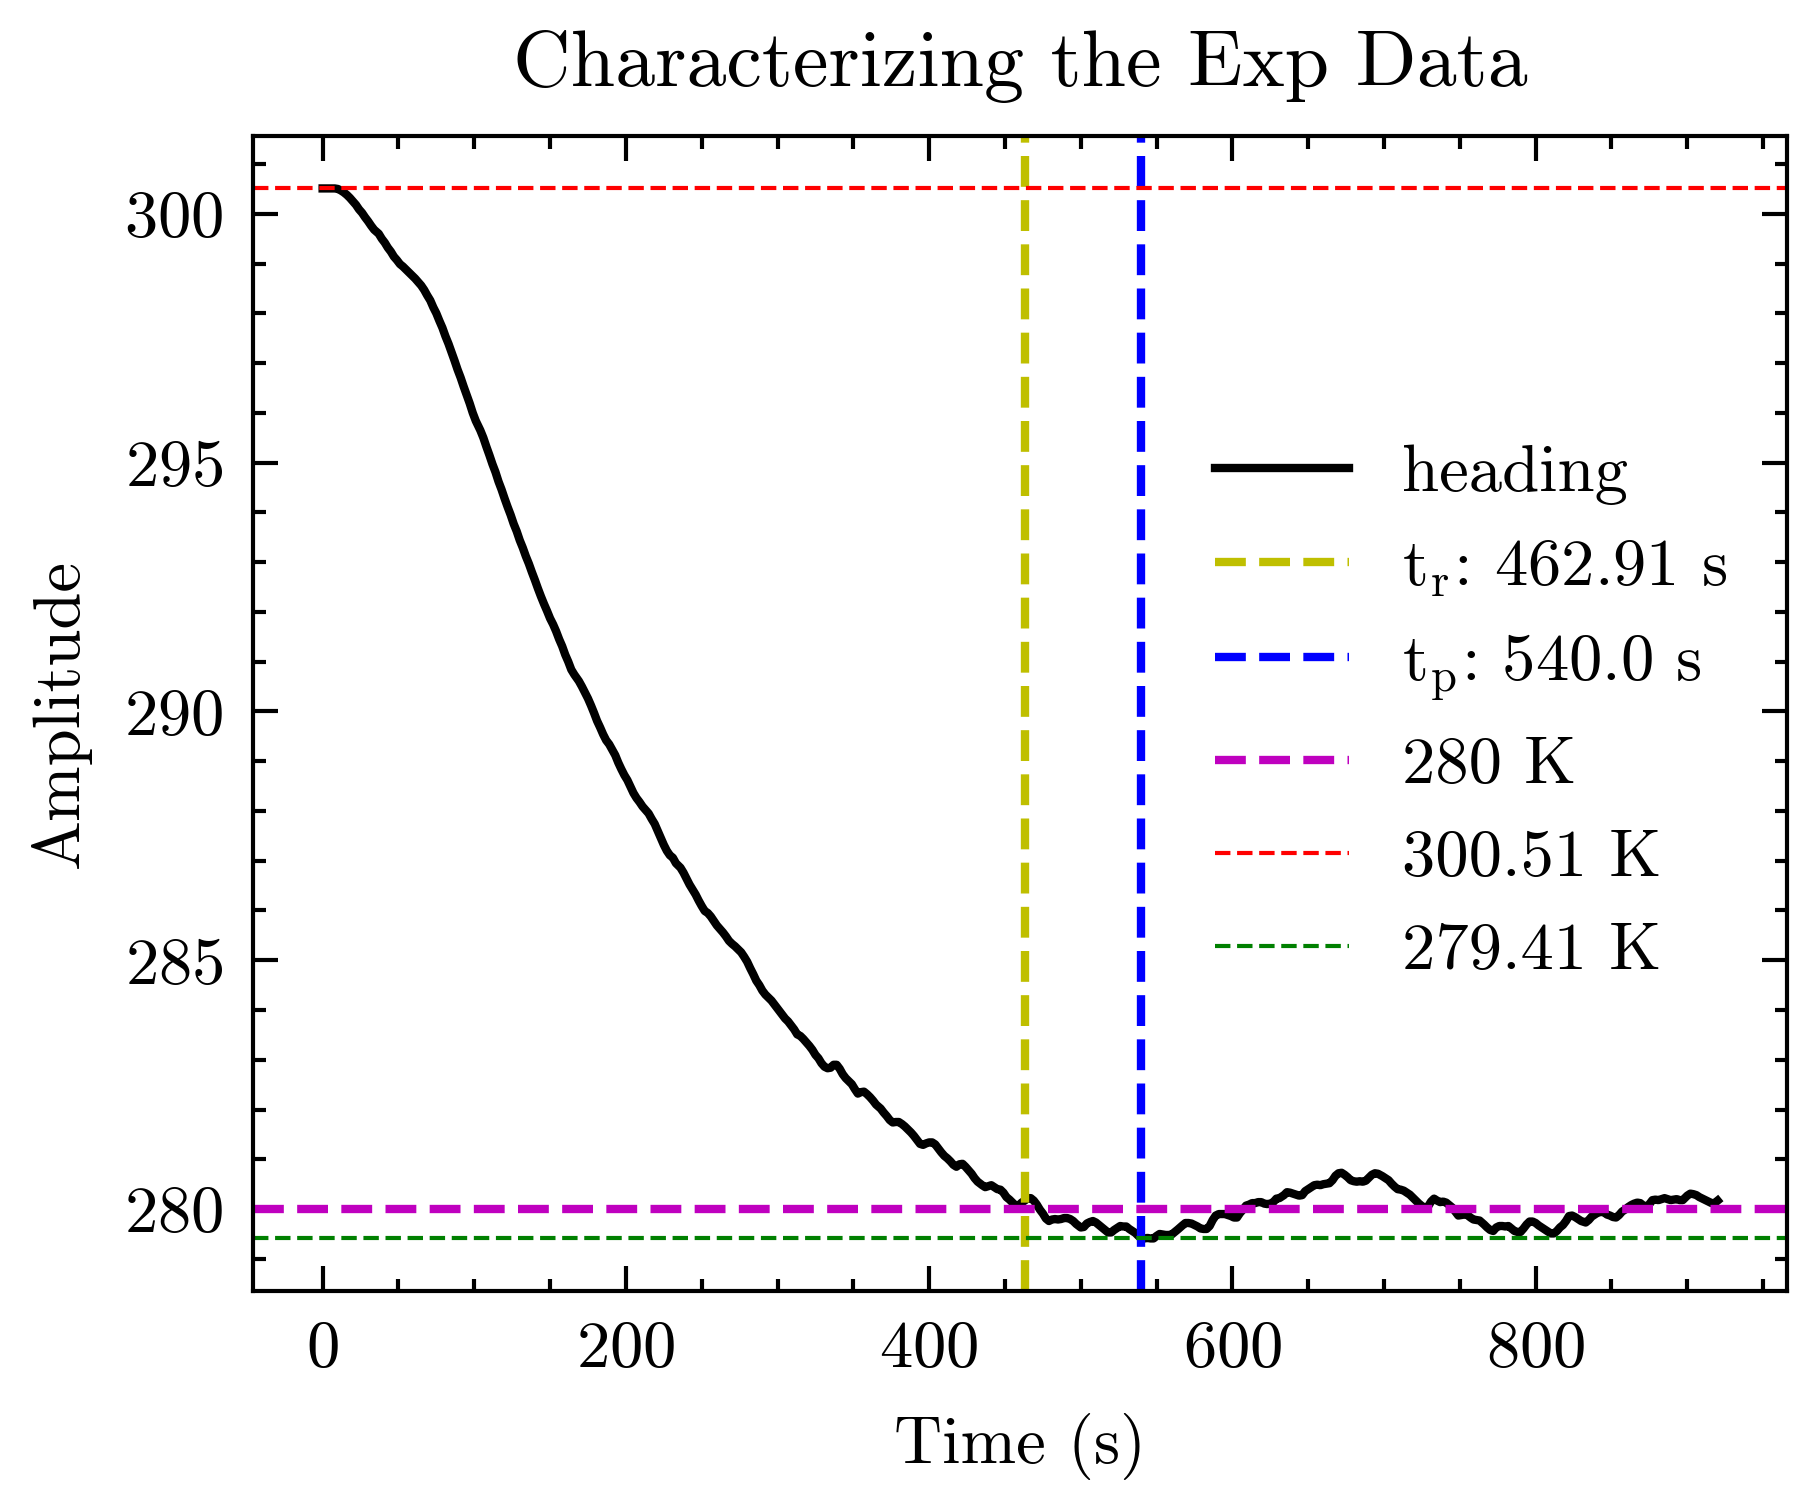

In [18]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(elapsed_time_seconds, tempcol, set_t)
characterized_system_plotter('Exp Data', elapsed_time_seconds, tempcol, rise_time, peak_time, set_t, False)

### CHARACTERIZING THE MODEL DATA

Peak temperature: 279.95678250002584 K
Percentage overshoot: -0.015 %
Peak time: 540.0 s
Rise time: 482.538 s
Damping Factor: 0.941
Natural Frequency: 0.017 rad/s


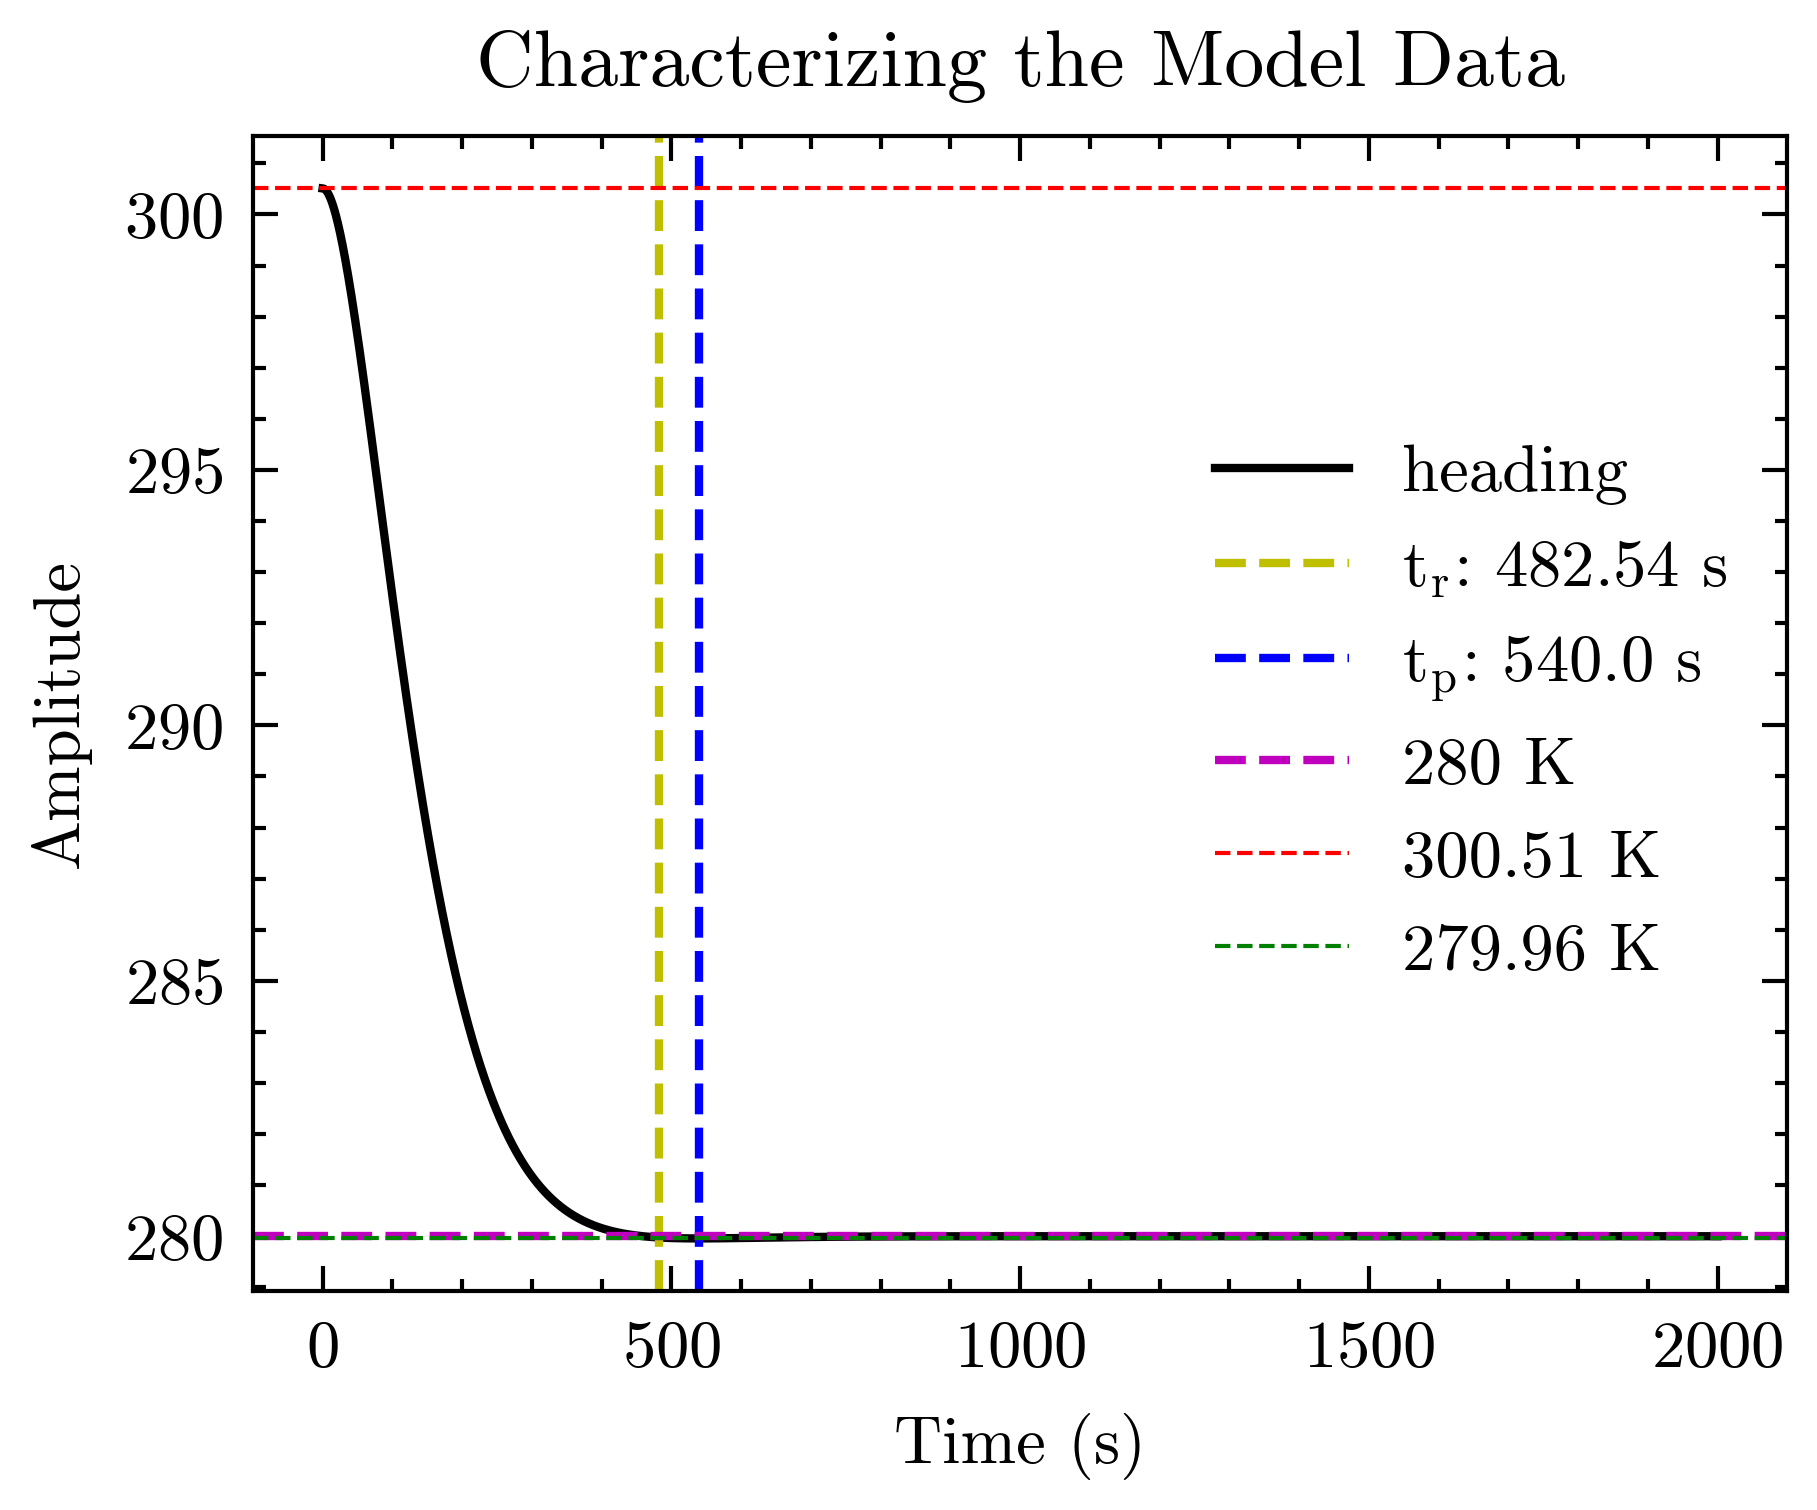

In [19]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(t_model, y_model_unnorm, set_t)
characterized_system_plotter('Model Data', t_model, y_model_unnorm, rise_time, peak_time, set_t, False)

### CHARACTERIZING THE TUNED DATA

Peak temperature: 278.7274557288759 K
Percentage overshoot: -0.454 %
Peak time: 87.73 s
Rise time: 73.872 s
Damping Factor: 0.864
Natural Frequency: 0.071 rad/s


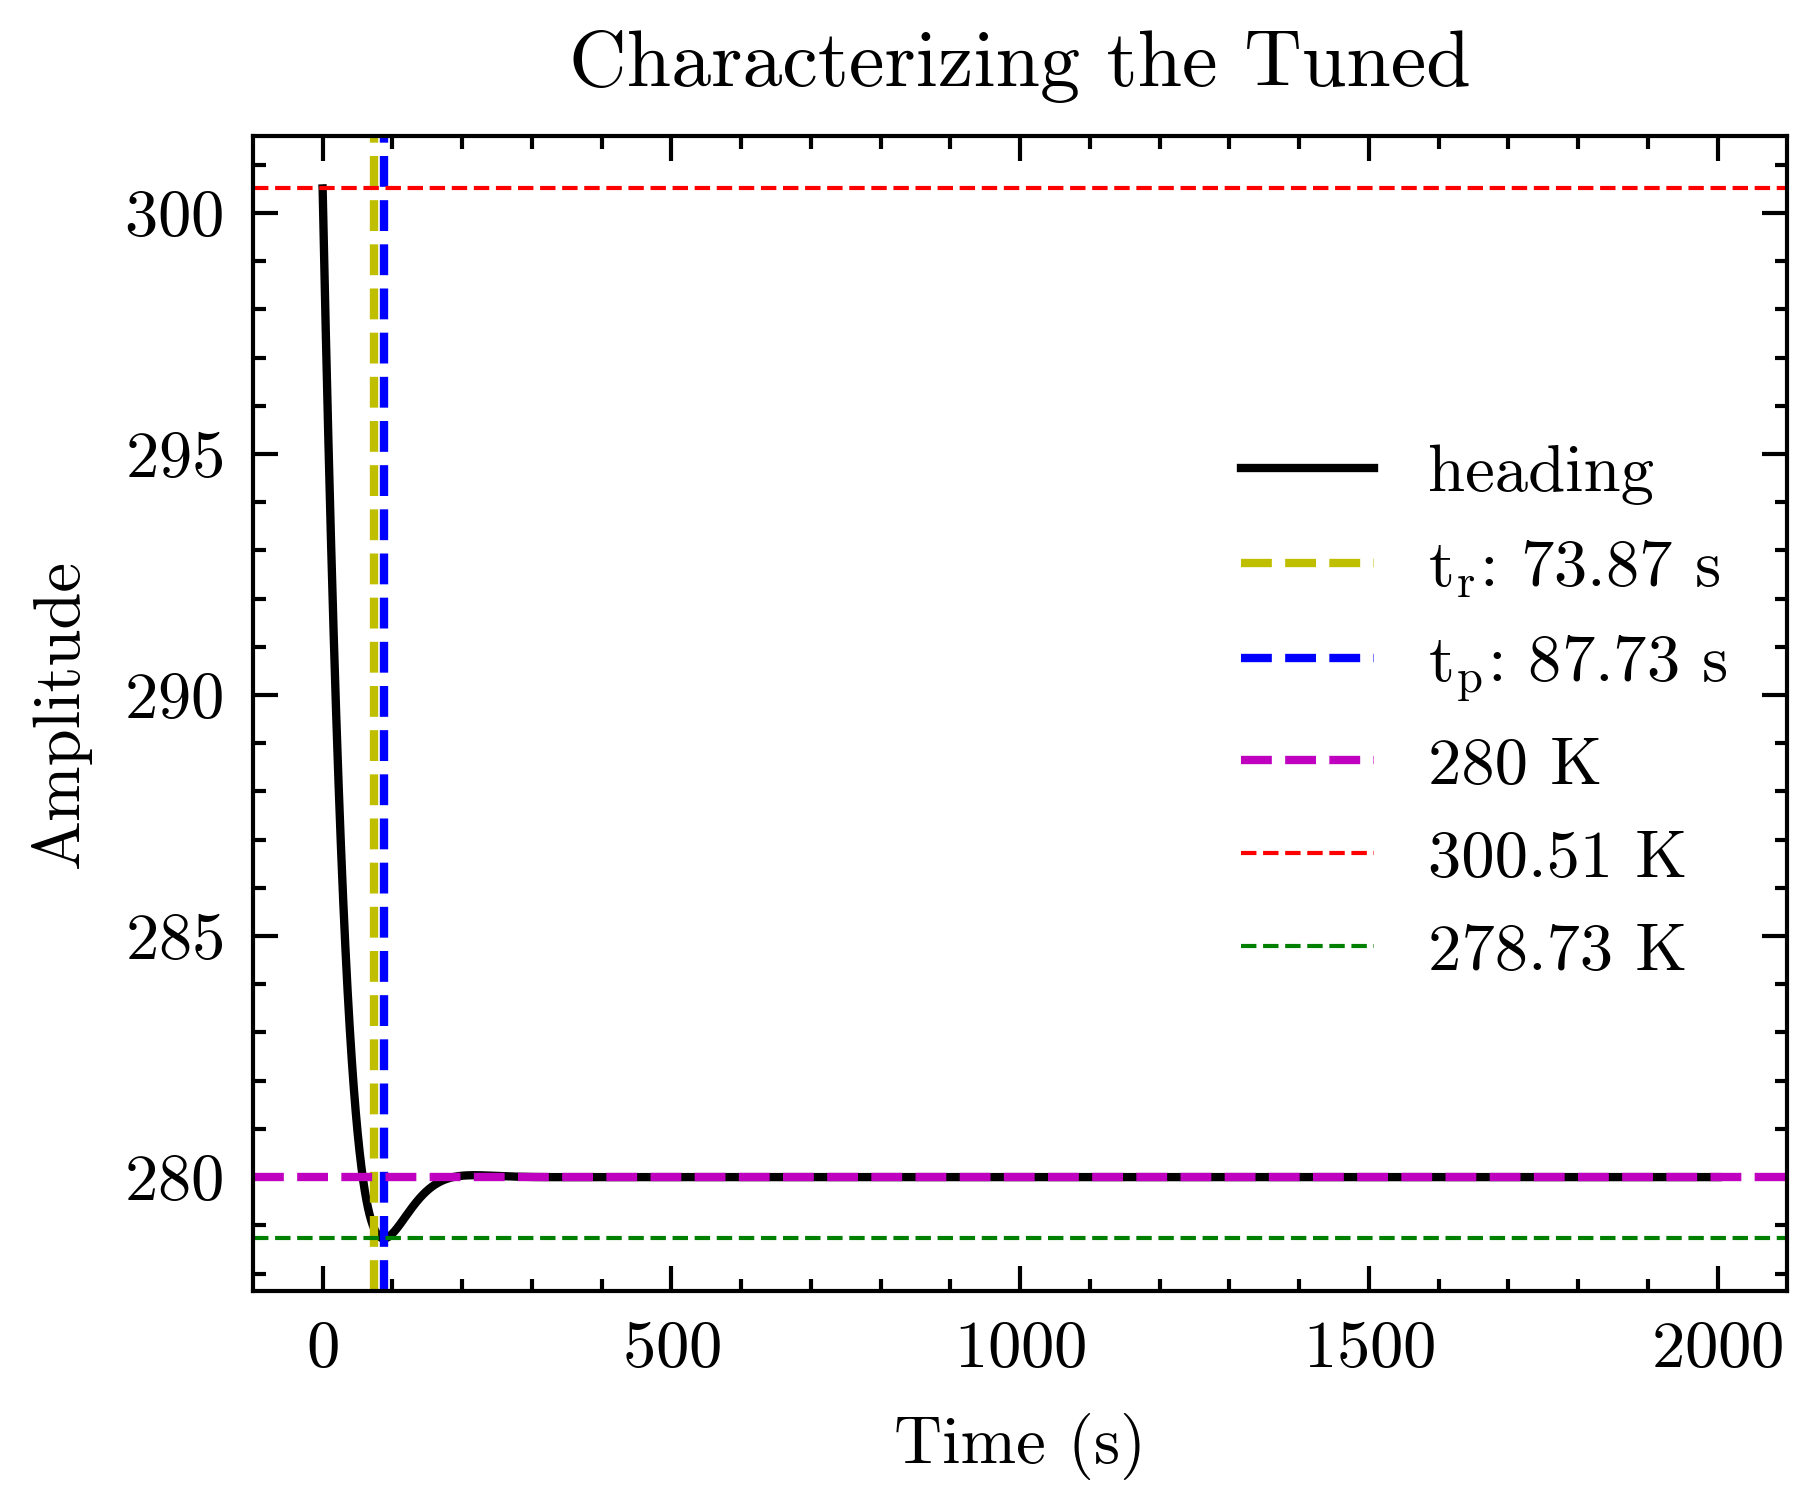

In [20]:
[T_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(t_model, y_tuned_unnorm, set_t)
characterized_system_plotter('Tuned', t_tuned, y_tuned_unnorm, rise_time, peak_time, set_t, False)

### Copper Model

In [77]:
#copper plate model
r = 3.5/200 #m
r_cu = 15/200 # metres
k = 398
l = 0.6/100  #length of cold tip
l_cu = 0.5/100
pho_cu = 9000 # kg/m3
c_cu = 385  # J/(Kg.K)

a = math.pi * r * r
a_cu = math.pi * r_cu * r_cu
mass_cu = a_cu * l_cu * pho_cu
mass = a * l * pho_cu

r_const = (1/k) * ((l_cu/a_cu) + (l/a))
# + (l/a)

copper_plate_TF = 1 - (r_const * mass * c_cu * s)
copper_plate_TF

TransferFunction(array([-0.32763693,  1.        ]), array([1]))

In [82]:
T

TransferFunction(array([-1.07515821e-05, -2.35974015e-04,  7.93509480e-04,  8.20388436e-05]), array([2.00000000e-01, 5.00455401e+00, 6.13882958e-01, 1.22054027e-02,
       8.20388436e-05]))

In [79]:
time, y_cu, T = custom_model_maker(P, C, copper_plate_TF)
[y_peak, peak_time, overshoot, rise_time, damp_f, w_n] = characterize(time, y_cu, set_t)

<TransferFunction>: sys[127]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


-1.075e-05 s^3 - 0.000236 s^2 + 0.0007935 s + 8.204e-05
--------------------------------------------------------
0.2 s^4 + 5.005 s^3 + 0.6139 s^2 + 0.01221 s + 8.204e-05

Peak temperature: 279.95367528813955 K
Percentage overshoot: -0.017 %
Peak time: 535.5 s
Rise time: 478.12 s
Damping Factor: 0.941
Natural Frequency: 0.017 rad/s


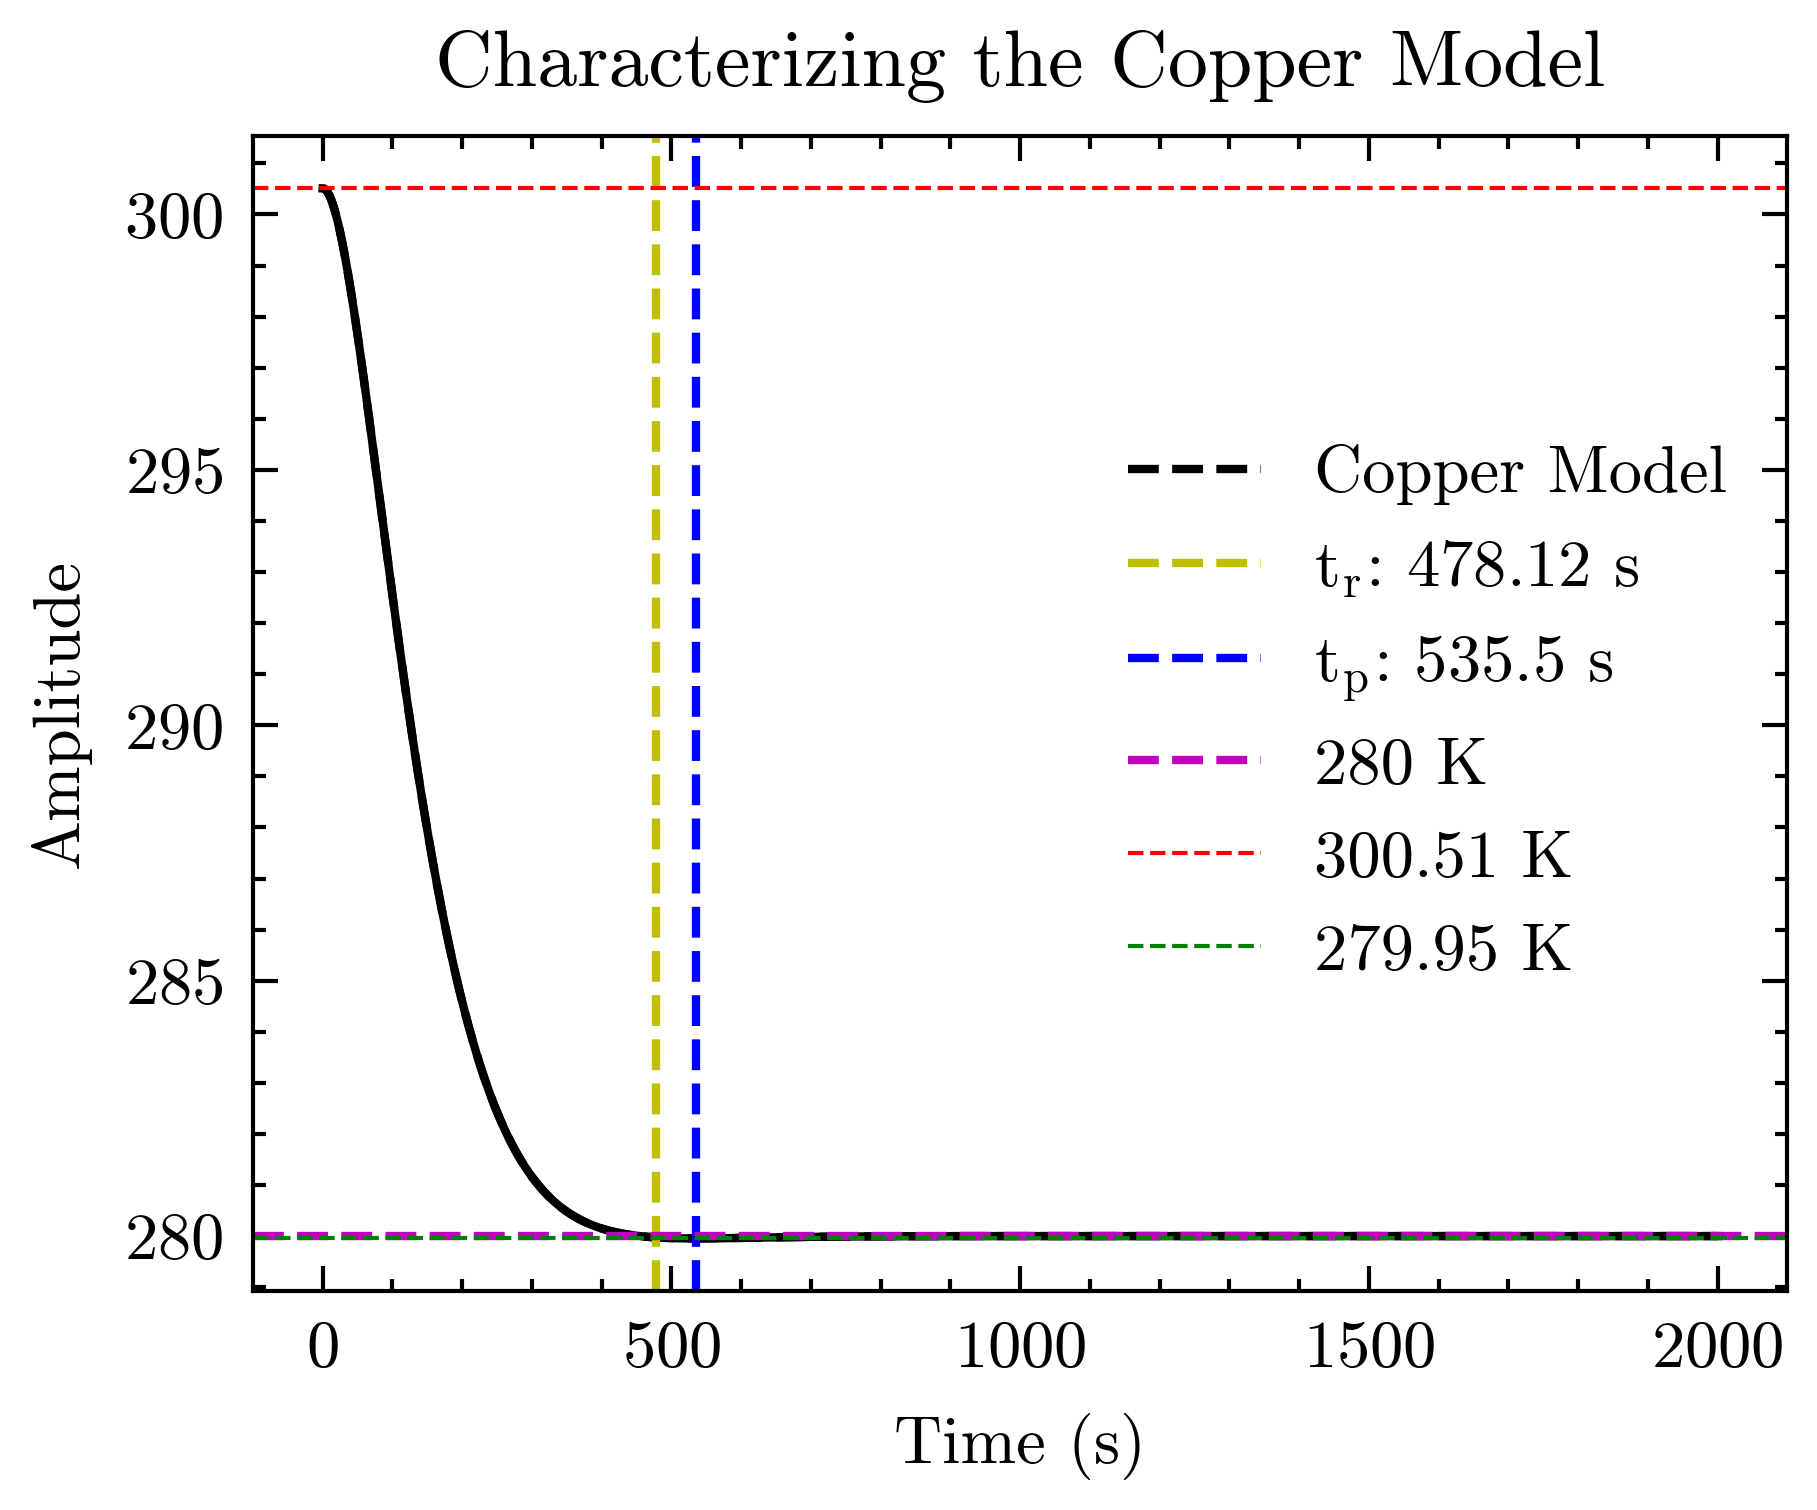

In [81]:
plt.plot(time, y_cu)
characterized_system_plotter("Copper Model", time, y_cu, rise_time, peak_time, set_t, True)

array([[list([<matplotlib.lines.Line2D object at 0x000001319EBA94D0>]),
        list([<matplotlib.lines.Line2D object at 0x000001319EBE5F90>]),
        list([<matplotlib.lines.Line2D object at 0x000001319EBE5CD0>, <matplotlib.lines.Line2D object at 0x000001319ED89410>, <matplotlib.lines.Line2D object at 0x000001319ED8BDD0>, <matplotlib.lines.Line2D object at 0x000001319ED8B250>])]],
      dtype=object)

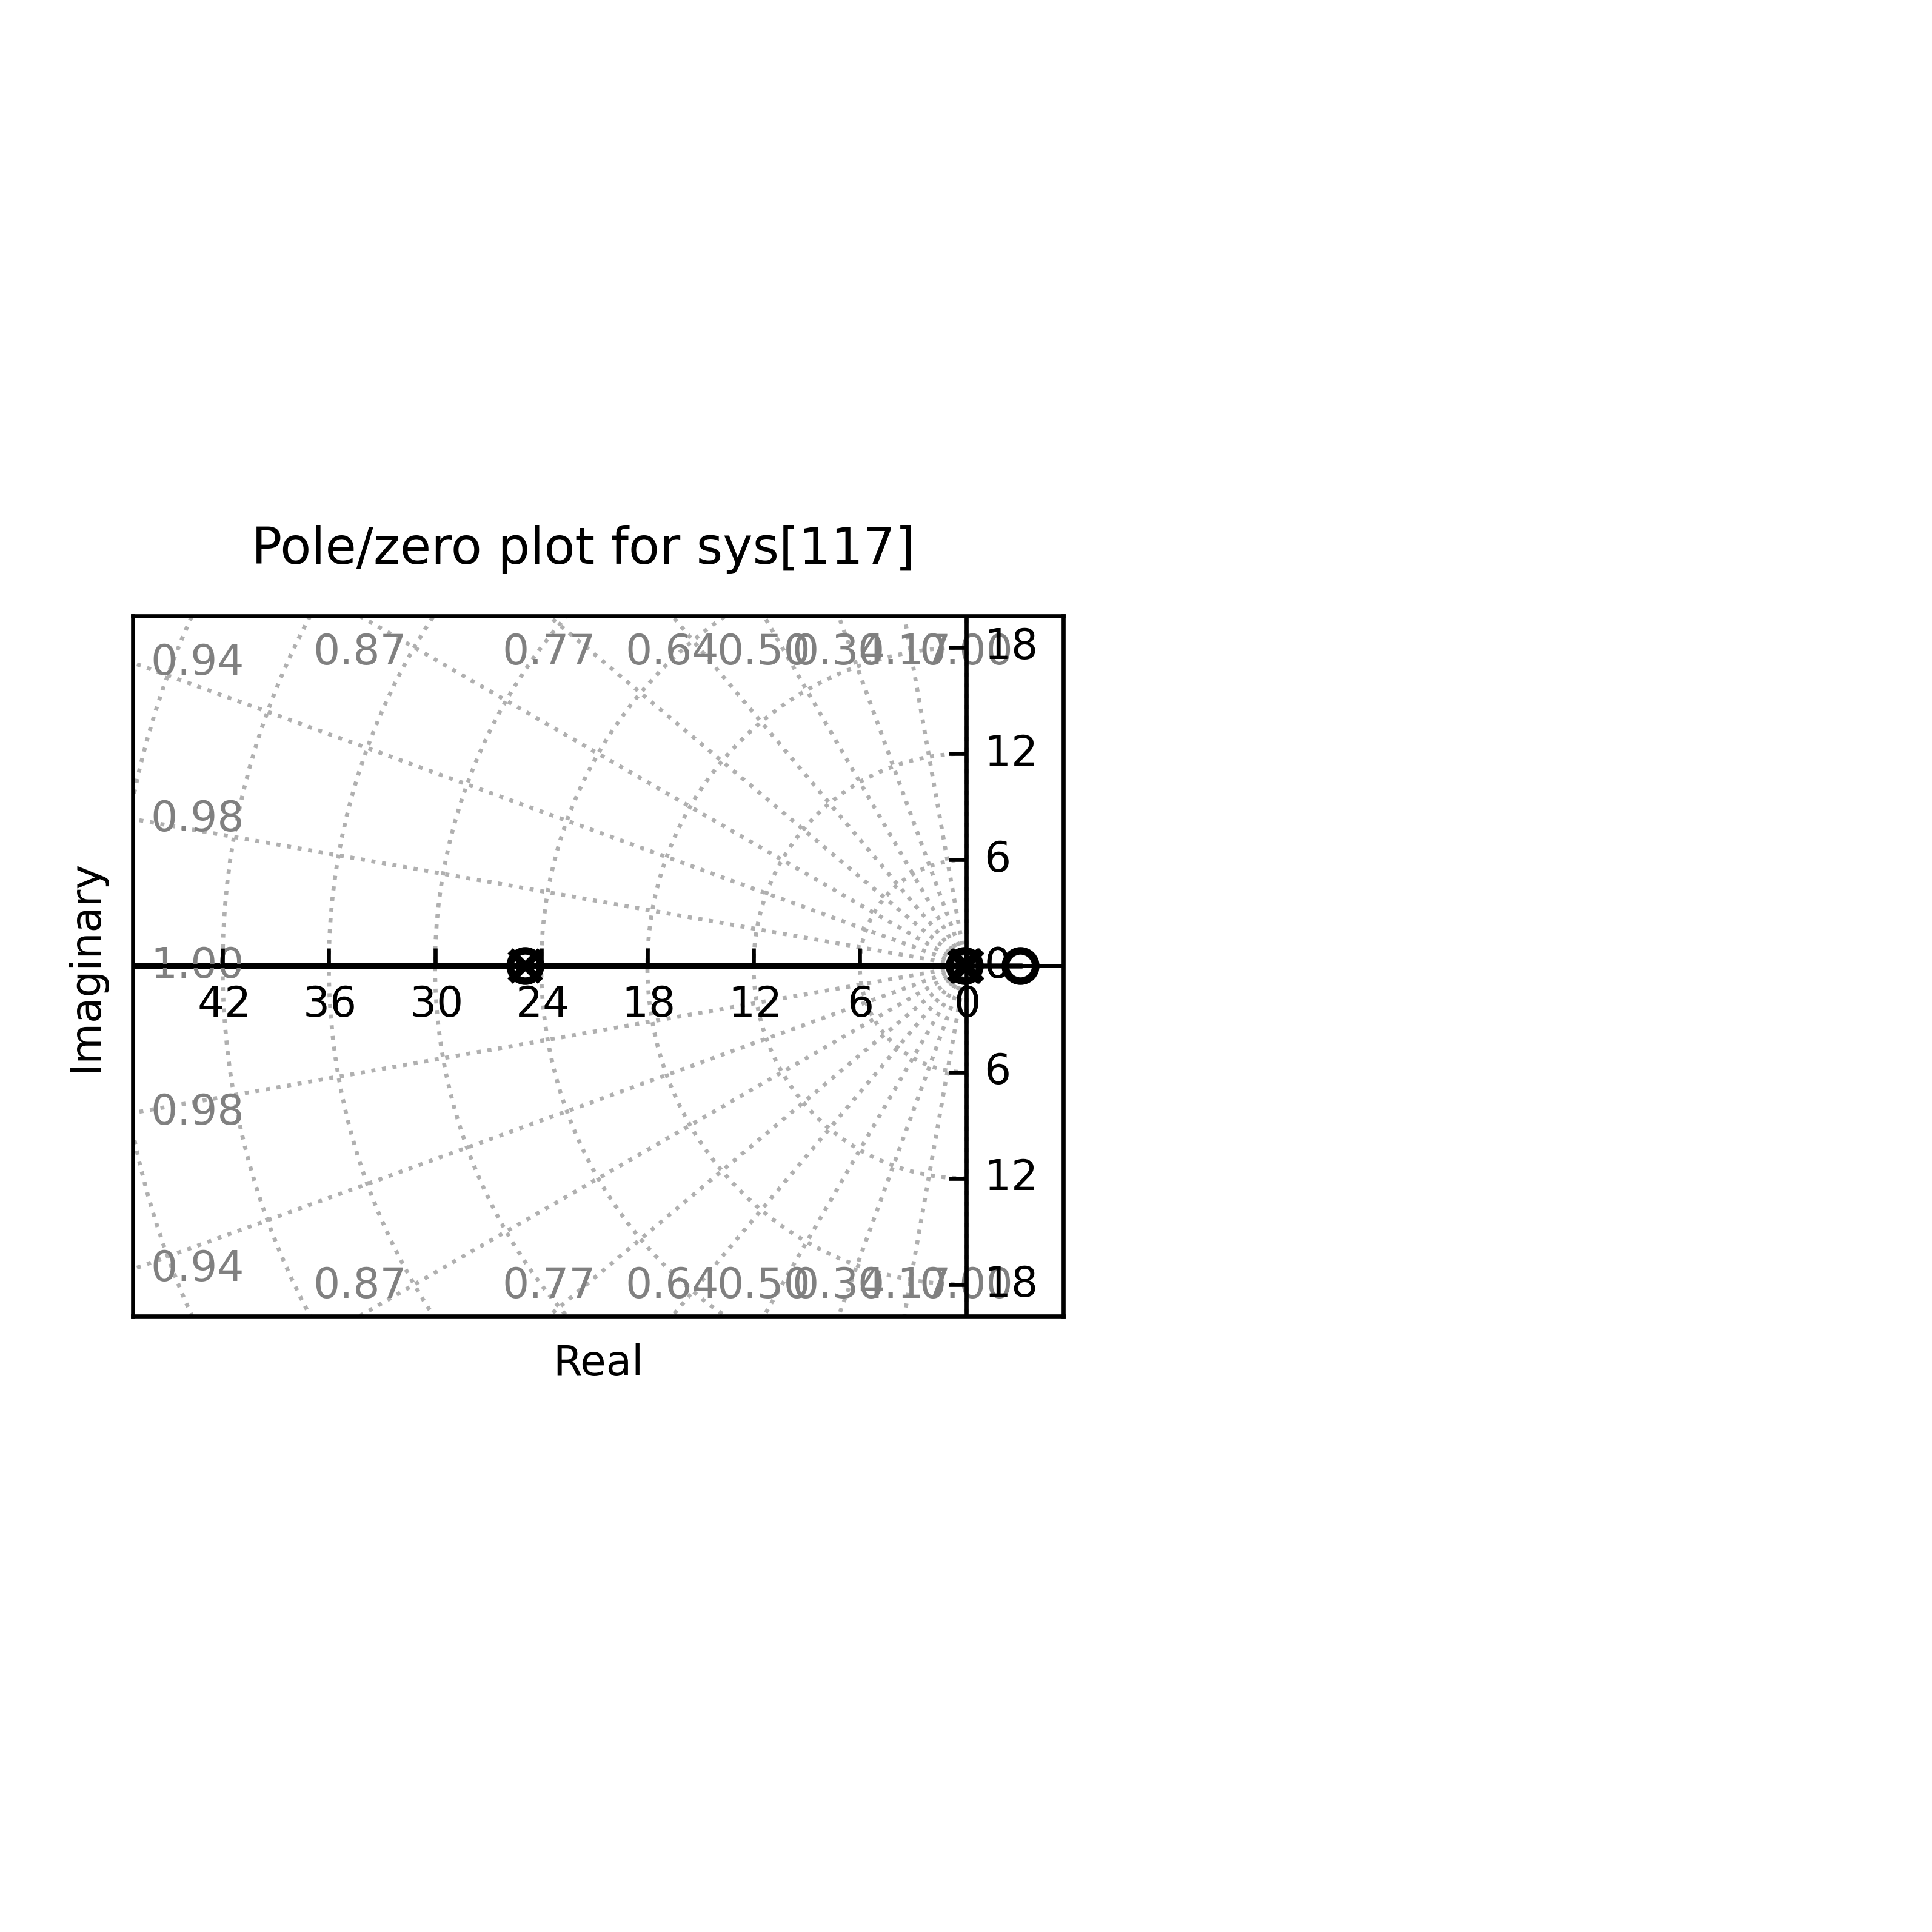

In [75]:
ct.root_locus_map(T).plot()

In [76]:
poles = ct.poles(T)
zeros = ct.zeros(T)


# Function to format poles and zeros
def format_complex_array(arr):
    formatted = []
    for num in arr:
        # If the imaginary part is very close to zero, just print the real part
        if np.isclose(num.imag, 0):
            formatted.append(f"{num.real:.6f}")
        else:
            formatted.append(f"{num.real:.6f} + {num.imag:.6f}j")
    return formatted

# Format poles and zeros
formatted_poles = format_complex_array(poles)
formatted_zeros = format_complex_array(zeros)

print("Poles:", formatted_poles)
print("Zeros:", formatted_zeros)

Poles: ['-24.899597', '-0.100403', '-0.028612', '0.005735']
Zeros: ['-24.899597', '3.052159', '-0.100403']
